In [102]:
import pandas as pd
import re

# Function to chunk text with overlap
def chunk_text(text, chunk_size, overlap):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size - overlap)]

metadata = pd.read_csv("extracted_data/main_doc_metadata.csv")

# print(metadata)
titles_simple_format = [
  "หมวดที่  2 ",
  "หมวดที่  3 ",
  "หมวดที่  4 ",
  "หมวดที่  5 ",
  "หมวดที่  6 ",
  "หมวดที่  8  ",
  "หมวดที่  9 ",
  "หมวดที่  10 ",
  "หมวดที่  1 1  "
]

titles_complex_format = [
  "หมวดที่  1 ",
  "หมวดที่  7 ",
]

data = []
for index, row in metadata.iterrows():
    if row["Section"] in titles_simple_format:
        print(row['Section'])
        chunks = chunk_text(row['Text'], 500, 100)
        print(len(chunks))
        for chunk in chunks:
            data.append([row['Section'], row['Description'], chunk])


def extract_sections_2(text):
    # Extract Section 1
    start_part_1 = text.find("ข้อ  1 .")
    end_part_1 = text.find("-2-", start_part_1)
    part_1 = text[start_part_1:end_part_1]

    # Extract Introduction and Section 2
    end_introduction = start_part_1
    introduction = text[:end_introduction]

    start_part_2 = text.find("ข้อ  2 .")
    end_part_2 = text.find("-6-", start_part_2)
    part_2 = text[start_part_2:end_part_2]

    return introduction, part_1, part_2

def extract_sections_7(text, num_parts):
    parts = []

    for i in range(1, num_parts + 1):
        start_marker = f"ข้อ  {i} ."
        end_marker = f"ข้อ  {i+1} ." if i < num_parts else None  # The end marker for the last part is None

        start = text.find(start_marker)
        end = text.find(end_marker, start) if end_marker else len(text)

        part = text[start:end].strip()  # Remove any leading/trailing whitespace
        parts.append(part)

    return parts
def process_section_7_part_3(text):
    pattern = r'(ตักเตือนด้วยวาจา)(.*?)(ตักเตือนเป็นหนังสือ)(.*?)(ตัดเงินรางวัลพิเศษประจาปี)(.*?)(เลิกจ้าง)(.*)'

    matches = re.search(pattern, text, re.DOTALL)
    action_authorer = ""
    if matches:
        for i in range(1, 8, 2):
            action = matches.group(i).strip()
            authority = matches.group(i + 1).strip()
            action_authorer += f"\n action to authorer pair: \n ระดับโทษทางวินัย: {action} - ผู้มีอ านาจหน้าที่ลงโทษ: {authority}\n"
            # print(f"Action: {action} - Authorizor: {authority}\n")
    intro_sentence = """ข้อ  3 . อานาจหน้าที่ในการลงโทษทางวินัย  
            ให้ผู้บังคับบัญชาตามสายงานมีสิทธิและอานาจหน้าที่ในการลงโทษทางวินัยดังนี้"""
    # print(intro_sentence + action_authorer)
    return intro_sentence + action_authorer



# data = []
for index, row in metadata.iterrows():
    if row["Section"] in titles_complex_format:
        if row["Section"] == titles_complex_format[0]:
            introduction, part_1, part_2 = extract_sections_2(row['Text'])
            chunks = chunk_text(introduction + part_2, 500, 100)
            for chunk in chunks:
                data.append([row['Section'], row['Description'], chunk])
        elif row["Section"] == titles_complex_format[1]:
            part_1, part_2, part_3, part_4, part_5 = extract_sections_7(row['Text'], 5)
            revised_pattern_with_space = r'(\d \.\d\.\d{1,2} ?\d{0,2})\s*(.*?)ตั้งแต่(.*?)จนถึง(.*?)(?=\d \.\d\.\d{1,2} ?\d{0,2}|$)'
            replacement = r'\1\nวินัย: \2\nระดับโทษ: ตั้งแต่\3จนถึง\4\n'
            part_2_new = re.sub(revised_pattern_with_space, replacement, part_2, flags=re.DOTALL)
            chunks = chunk_text(part_1 + "\n" + part_2_new + "\n" + process_section_7_part_3(part_3) + "\n" + part_4 +"\n" +  part_5, 500, 100)
            
            for chunk in chunks:
                data.append([row['Section'], row['Description'], chunk])

final_df = pd.DataFrame(data, columns=['Section', 'Description', "chunk"])

final_df.to_csv('extracted_data/main_doc_chunks.csv', index=False)
            

หมวดที่  2 
4
หมวดที่  3 
6
หมวดที่  4 
6
หมวดที่  5 
2
หมวดที่  6 
20
หมวดที่  8  
9
หมวดที่  9 
13
หมวดที่  10 
41
หมวดที่  1 1  
10


In [94]:
# Use regex to reformat the text
import re
reformatted_text = re.sub(r'(\d+\.)\s*(ระดับโทษทางวินัย:.*?)\n', r'\1 \2 -', part_3)

print(reformatted_text)

ข้อ  3 . อานาจหน้าที่ในการลงโทษทางวินัย  
          ให้ผู้บังคับบัญชาตามสายงานมีสิทธิและอานาจหน้าที่ในการลงโทษทางวินัยดังนี้   
 
ระดับโทษทางวินัยผู้มีอานาจหน้าที่ลงโทษ  
ตักเตือนด้วยวาจาผู้บังคับบัญชาโดยตรงตั้งแต่ระดับผู้จัดการส่วนขึ้นไป  
ตักเตือนเป็นหนังสือผู้บังคับบัญชาโดยตรงตั้งแต่ระดับผู้อานวยการฝ่ายขึ้นไป  
ตัดเงินรางวัลพิเศษประจาปี   
 ผู้บังคับบัญชาโดยตรงตั้งแต่ระดับผู้อานวยการฝ่ายขึ้นไป  
โดยได้รับความเห็นชอบจากกรรมการผู้จัดการใหญ่  
เลิกจ้างกรรมการผู้จัดการใหญ่  
 
 การลงโทษทางวินัยตั้งแต่ตัดเงินรางวัลพิเศษประจาปีถึงเลิกจ้างนั้นผู้มีอานาจหน้าที่ลงโทษอาจแต่งตั้ง
คณะกรรมการเพื่อสอบสวนข้อเท็จจริงก่อนพิจารณาลงโทษทางวินัยได้  -17-


In [95]:
part_3

'ข้อ  3 . อานาจหน้าที่ในการลงโทษทางวินัย  \n          ให้ผู้บังคับบัญชาตามสายงานมีสิทธิและอานาจหน้าที่ในการลงโทษทางวินัยดังนี้   \n \nระดับโทษทางวินัยผู้มีอานาจหน้าที่ลงโทษ  \nตักเตือนด้วยวาจาผู้บังคับบัญชาโดยตรงตั้งแต่ระดับผู้จัดการส่วนขึ้นไป  \nตักเตือนเป็นหนังสือผู้บังคับบัญชาโดยตรงตั้งแต่ระดับผู้อานวยการฝ่ายขึ้นไป  \nตัดเงินรางวัลพิเศษประจาปี   \n ผู้บังคับบัญชาโดยตรงตั้งแต่ระดับผู้อานวยการฝ่ายขึ้นไป  \nโดยได้รับความเห็นชอบจากกรรมการผู้จัดการใหญ่  \nเลิกจ้างกรรมการผู้จัดการใหญ่  \n \n การลงโทษทางวินัยตั้งแต่ตัดเงินรางวัลพิเศษประจาปีถึงเลิกจ้างนั้นผู้มีอานาจหน้าที่ลงโทษอาจแต่งตั้ง\nคณะกรรมการเพื่อสอบสวนข้อเท็จจริงก่อนพิจารณาลงโทษทางวินัยได้  -17-'

In [96]:
part_2

'ข้อ  2 . ระดับโทษทางวินัยและวินัยซึ่งพนักงานจะต้องรักษามีดังนี้  \n2 .1  ระดับโทษทางวินัยแบ่งเป็น 4 ระดับจากโทษเบาไปหาโทษหนักคือ  \n   2 .1.1  ตักเตือนด้วยวาจา  \n 2 .1.2  ตักเตือนเป็นหนังสือ  \n 2 .1.3  ตัดเงินรางวัลพิเศษประจาปี  \n 2 .1.4  เลิกจ้าง  \n2.2 วินัยซึ่งพนักงานจะต้องรักษาและระดับโทษสาหรับพนักงานที่ฝ่าฝืนวินัย  \nวินัยระดับโทษ  \n2 .2.1   ต้องปฏิบัติตามข้อบังคับระเบียบคาสั่งและประกาศของบริษัทฯตั้งแต่ตักเตือนด้วยวาจาจนถึงเลิกจ้าง  \n2 .2.2   ต้องเชื่อฟังและปฏิบัติตามคาสั่งโดยชอบของผู้บังคับบัญชาตั้งแต่ตักเตือนเป็นหนังสือจนถึงตัด\nเงินรางวัลพิเศษประจาปี  \n2 .2.3   ต้องปฏิบัติงานด้วยความซื่อสัตย์สุจริตอุตสาหะและตรงต่อเวลาตั้งแต่ตักเตือนด้วยวาจาจนถึงเลิกจ้าง  \n2 .2.4   ต้องควบคุมดูแลพนักงานใต้บังคับบัญชาให้ปฏิบัติตามวินัยโดยตั้งแต่ตักเตือนเป็นหนังสือจนถึงตัด-15- \n \n วินัยระดับโทษ  \n          เคร่งครัดถ้ารู้ว่าพนักงานผู้ใดกระทาความผิดแล้วไม่รายงานให้  \n          ผู้บังคับบัญชาเหนือชั้นขึ้นไปทราบถือว่าผู้บังคับบัญชานั้นกระทา    \n          ผิดวินัยด้วยเงินรางวัลพิเศษประจาป

In [101]:
pd.DataFrame(data).to_csv("test.csv")

In [98]:
pd.DataFrame(data).iloc[8][2]

'ข้อ  1 . พนักงานทุกคนต้องรักษาไว้ซึ่งวินัยของบริษัทฯโดยเคร่งครัดข้อ  3 . อานาจหน้าที่ในการลงโทษทางวินัย  \n            ให้ผู้บังคับบัญชาตามสายงานมีสิทธิและอานาจหน้าที่ในการลงโทษทางวินัยดังนี้\n action to authorer pair: \n ระดับโทษทางวินัย: ตักเตือนด้วยวาจา - ผู้มีอ านาจหน้าที่ลงโทษ: ผู้บังคับบัญชาโดยตรงตั้งแต่ระดับผู้จัดการส่วนขึ้นไป\n\n action to authorer pair: \n ระดับโทษทางวินัย: ตักเตือนเป็นหนังสือ - ผู้มีอ านาจหน้าที่ลงโทษ: ผู้บังคับบัญชาโดยตรงตั้งแต่ระดับผู้อานวยการฝ่ายขึ้นไป\n\n action to authore'

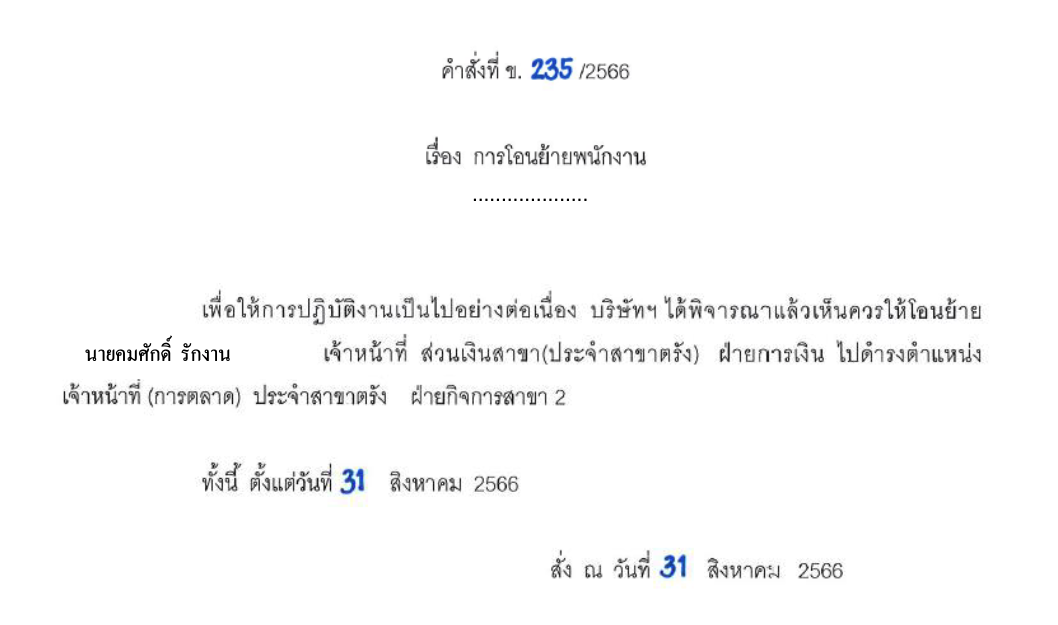

In [11]:
from PIL import Image
import pytesseract

img_path = 'assets/img/img2.png'
Image.open(img_path)

In [12]:
# Python - using pytesseract for Thai language

txtImg = Image.open(img_path)
text = pytesseract.image_to_string(txtImg, 'tha')

print(text)

ค้าสั่งที่ ข. 235 /2566

"!                          2,           5
เรือง การโอนย้ายพนักงาน

ฉี่        “           โพ ล           ร
เพื่อให้การปฏิบัติงานเป็นไปอย่างต่อเนื่อง บริษัทฯ ได้พิจารณาแล้วเห็นควรให้โอนข้าย
นายคมศักดิ์ รักงาน       เจ้าหน้าที่ ล่วนเงินสาขา(ประจําสาขาตรัง) ฝ่ายการเงิน ไปดํารงตําแหน่ง

เจ้าหน้าที่ (การตลาด) ประจําสาขาตรัง ฝ่ายกิจการสาขา 2

 '
ทั้งนี้ ตั้งแต่วันที่ 31 สิงหาคม 2566

สั่ง ณ วันที่ 31 สิงหาคม 2566

